# Retraining
Here we explore the differences between LightGBM and XGBoost in a retraining setting

The two datasets used are a BCI and Airline dataset. 

In [1]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt, curry
import pandas as pd
import os
import io
from PIL import Image
import base64
%matplotlib inline 

In [2]:
bci_notebook = '02_BCI.ipynb'

In [3]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [4]:
@curry
def read_cell(cell_key, nb):
    """ Returns code cell that starts with cell_key
    """
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith(cell_key):
            return cell

In [5]:
def read_image(cell):
    return pipe(cell['outputs'][0]['data']['image/png'],
                base64.b64decode,
                io.BytesIO,
                Image.open)

In [6]:
def read_img_from_nb(notebook_name, cell_key):
    """ Reads image from notebook
    """
    return pipe(notebook_name,
                read_notebook,
                read_cell(cell_key),
                read_image)

## BCI
In this dataset we likely have a mixture of virtual concept drift and true concept drift. This is due to number of factors including changes in electrode impedance as well as changes to the underlying neural phenomena observed. Since these changes are expected to occur gradually we also expect the concept drift to gradually change. In the example below we naiviley retrain at a regular interval. No effort is carried out to try and select samples to retrain with which would eventually lead to the model learning to model the noise as performance continues to degrade

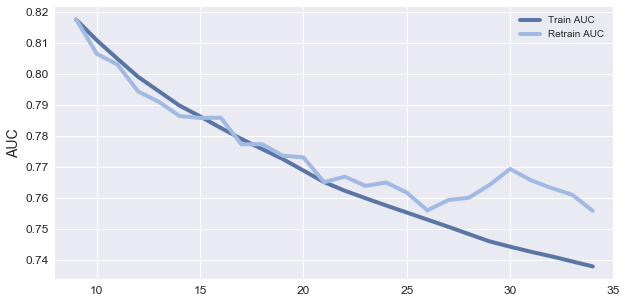

In [7]:
read_img_from_nb(bci_notebook, '# XGB Retrain Results')

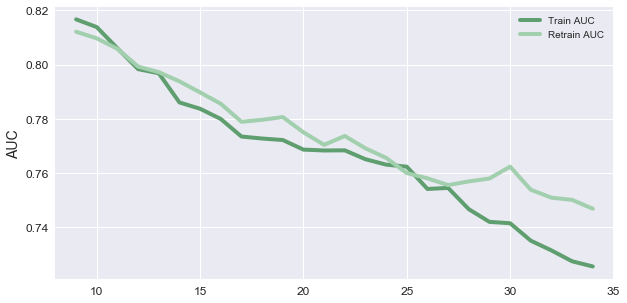

In [8]:
read_img_from_nb(bci_notebook, '# LGBM Retrain Results')

Overall we can see that naive retraining improves performance slightly especially in the later epochs. It also seems that XGBoost is able to achieve a slightly better AUC than LightGBM.

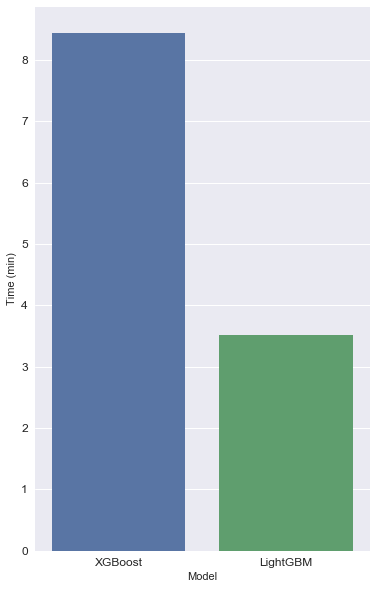

In [9]:
read_img_from_nb(bci_notebook, '# XGB vs LGBM Retrain Time')

Above is the total time taken to run the train retrain experiment. we can see that LightGBM is over twice as fast as XGBoost.

## Airline